In [ ]:
!pip install torch
!pip install einops
!pip install sidechainnet
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torchvision import transforms as TV
import os
import numpy as np
import time
from tqdm import tqdm
from torch.utils import data
import sidechainnet as scn
import einops
import gc
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader

     |████████████████████████████████| 47.6 MB 1.5 MB/s 
     |████████████████████████████████| 12.0 MB 63.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.3 MB 56.1 MB/s 
  Created wheel for ProDy: filename=ProDy-2.1.2-cp37-cp37m-linux_x86_64.whl size=10833899 sha256=7c26a22f84824e6fbda4c23067870b40730e8499473be149fbf36fbdfc531070
  Stored in directory: /root/.cache/pip/wheels/e0/b5/8d/051404fbe4394c1b6336fd178bf639d3869353ce058bdbcd36
Successfully built ProDy


@> ProDy is configured: verbosity='none'


In [ ]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

using device: cuda:0


## Load CASP7 data as pytorch tensors

In [ ]:
data = scn.load(casp_version=7, with_pytorch="dataloaders", 
                seq_as_onehot=True, aggregate_model_input=False,
               batch_size=30)

SidechainNet(7, 30) was not found in ./sidechainnet_data.


Downloaded SidechainNet to ./sidechainnet_data/sidechainnet_casp7_30.pkl.
SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_30.pkl.


## Creates features for a batch of sequences

In [ ]:
def get_seq_features(batch):
    '''
    Take a batch of sequence info and return the sequence (one-hot),
    evolutionary info and (phi, psi, omega) angles per position, 
    as well as position mask.
    Also return the distance matrix, and distance mask.
    '''
    str_seqs = batch.str_seqs # seq in str format
    seqs = batch.seqs # seq in one-hot format
    int_seqs = batch.int_seqs # seq in int format
    masks = batch.msks # which positions are valid
    lengths = batch.lengths # seq length
    evos = batch.evos # PSSM / evolutionary info
    angs = batch.angs[:,:,0:2] # torsion angles: phi, psi
    
    # use coords to create distance matrix from c-beta
    # except use c-alpha for G
    # coords[:, 4, :] is c-beta, and coords[:, 1, :] is c-alpha
    #coords = batch.crds # seq coord info (all-atom)
    #batch_xyz = []
    #for i in range(coords.shape[0]):
    #    xyz = []
    #    xyz = [coords[i][cpos+4,:] 
    #            if masks[i][cpos//14] and str_seqs[i][cpos//14] != 'G'
    #            else coords[i][cpos+1,:]
    #            for cpos in range(0, coords[i].shape[0]-1, 14)]
    #    batch_xyz.append(torch.stack(xyz))
    #batch_xyz = torch.stack(batch_xyz)
    #print(batch_xyz.shape)
    # now create pairwise distance matrix
    #dmats = torch.cdist(batch_xyz, batch_xyz)
    # create matrix mask (0 means i,j invalid)
    #dmat_masks = torch.einsum('bi,bj->bij', masks, masks)

    # carbon pos
    carbon_pos = batch.crds
    # pos: N, C-alpha, C
    carbon_pos = einops.rearrange(carbon_pos, 'b (m n) c -> b m n c', n=14)
    carbon_pos = carbon_pos[:,:,:3,:]
    
    
    return seqs, evos, angs, masks, carbon_pos

In [ ]:
#for idx, batch in enumerate(data['train']):
#   seqs, evos, angs, masks, dmats, dmat_masks, carbon_poses = get_seq_features(batch)
#   print(seqs.shape, evos.shape, angs.shape, dmats.shape, carbon_poses.shape)
#   break

## Pair Representation

In [ ]:
class PairRep(nn.Module):
    def __init__(self):
        super(PairRep, self).__init__()

        self.fcA = nn.Linear(20, 128)
        self.fcB = nn.Linear(20, 128)
    
    def forward(self, seqs):
        seq_len = seqs.size(dim=1)
        A = self.fcA(seqs.to(torch.float))
        B = self.fcB(seqs.to(torch.float))
        As = A.repeat(seq_len, 1, 1, 1)
        pair_rep = torch.transpose(As, 0, 1)
        pair_rep = torch.transpose(pair_rep, 1, 2)

        Bs = B.repeat(seq_len, 1, 1, 1)
        pair_rep = pair_rep + torch.transpose(Bs, 0, 1)

        return pair_rep

## MSI resp

In [ ]:
class MSA(nn.Module):
    def __init__(self, n_cluster):
        super(MSA, self).__init__()

        self.n_cluster = n_cluster
        self.fcA = nn.Linear(21, 256)
    
    def forward(self, evos):
        msa = self.fcA(evos)
        msa = torch.unsqueeze(msa, dim=1)
        msa = msa.repeat((1,self.n_cluster,1,1))

        return msa

## Row Attention

In [ ]:
class RowAttention(nn.Module):
    '''Self Attention'''

    def __init__(self, d, dk,num_heads):
        '''define WQ, WK, WV projection matrices:
        d: d_model is the original model dimension
        dk: projection dimension for query, keys and values
        '''
        super(RowAttention, self).__init__()
        
        self.d = d  # d_model
        self.dk = dk  # d_k: projection dimension
        self.B_map = nn.Linear(128,1, bias=False)
        self.G_map = nn.Linear(256,1, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.num_heads = num_heads  # number of attention heads
        self.WQ = nn.Linear(self.d, self.dk * self.num_heads, bias=False)
        self.WK = nn.Linear(self.d, self.dk * self.num_heads, bias=False)
        self.WV = nn.Linear(self.d, self.dk * self.num_heads, bias=False)
        self.WO = nn.Linear(self.dk * self.num_heads, self.d, bias=False)

    def forward(self, msa_rep, pair_rep):
        '''project the context onto key, query and value spaces and
        return the final value vectors
        '''
        #print(msa_rep.shape) # batch, cluter, seq, msa=256 
        #print(pair_rep.shape) # b,c, seq, z= 128
        
        # calculate b first
        B = self.B_map(pair_rep).squeeze(3).unsqueeze(1).unsqueeze(1) # b,1,1,seq,seq
        Gate = self.G_map(msa_rep)
        Gate = self.sigmoid(Gate).unsqueeze(2) # b,1,1,gate,seq

        # input shape: (batch_size, block_size, d)
        # let batch_size=b, block_size=l, num_heads=h
        Q = self.WQ(msa_rep)  # shape: b, c, seq, dk
        K = self.WK(msa_rep)  # shape: b, c, seq, dk
        V = self.WV(msa_rep)  # shape: b, c, seq, dk

        # split Q, K, V into heads and dk, move heads up front; KT is transpose of K
        Q = einops.rearrange(
            Q, 'b c s (h dk)-> b c h s dk', h=self.num_heads
        )  # size: (b c h s dk)
        KT = einops.rearrange(
            K, 'b c s (h dk)-> b c h dk s', h=self.num_heads
        )  # size: (b c h dk s)
        V = einops.rearrange(
            V, 'b c s (h dk)-> b c h s dk', h=self.num_heads
        )  # size: (b c h s dk)


        QKT = torch.einsum('bchsd,bchdt->bchst', Q, KT)
        # size: b, c, h, seq, seq
        # attention matrix
        # row specifies weights for the value vectors, row add up; to one
        A = F.softmax(QKT / np.sqrt(self.dk) + B, dim=4)  # shape: b, c, h, seq, seq
        V = torch.einsum('bchst,bchtd->bchsd', A, V) #shape: b, c, h, seq, dk
        V = V * Gate
        V = einops.rearrange(V, 'b c h s d-> b c s (h d)') #shape: b, c, seq, h*dk
        output = self.WO(V)
        return output

## Column Attention

In [ ]:
class ColAttention(nn.Module):
    '''Self Attention'''

    def __init__(self, d, dk,num_heads):
        '''define WQ, WK, WV projection matrices:
        d: d_model is the original model dimension
        dk: projection dimension for query, keys and values
        '''
        super(ColAttention, self).__init__()
        
        self.d = d  # d_model
        self.dk = dk  # d_k: projection dimension
        self.num_heads = num_heads  # number of attention heads
        self.G_map = nn.Linear(256,1, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.WQ = nn.Linear(self.d, self.dk * self.num_heads, bias=False)
        self.WK = nn.Linear(self.d, self.dk * self.num_heads, bias=False)
        self.WV = nn.Linear(self.d, self.dk * self.num_heads, bias=False)
        self.WO = nn.Linear(self.dk * self.num_heads, self.d, bias=False)

    def forward(self, msa_rep, pair_rep):
        '''project the context onto key, query and value spaces and
        return the final value vectors
        '''
        #print(msa_rep.shape) # batch, cluter, seq, msa=256 
        #print(pair_rep.shape) # b,c, seq, z= 128
        
        msa_col_rep = einops.rearrange(msa_rep, 'b c s m-> b s c m')
        # shape: b, seq, c, 256
        Gate = self.G_map(msa_col_rep)
        Gate = self.sigmoid(Gate).unsqueeze(2) # b,1,gate,seq

        # input shape: (batch_size, block_size, d)
        # let batch_size=b, block_size=l, num_heads=h
        Q = self.WQ(msa_col_rep)  # shape: b, seq, c, h*dk
        K = self.WK(msa_col_rep)  # shape: b, seq, c, h*dk
        V = self.WV(msa_col_rep)  # shape: b, seq, c, h*dk

        
        # split Q, K, V into heads and dk, move heads up front; KT is transpose of K
        Q = einops.rearrange(
            Q, 'b seq c (h dk)-> b seq h c dk', h=self.num_heads
        )  # size: (b seq h c dk)
        KT = einops.rearrange(
            K, 'b seq c (h dk)-> b seq h dk c', h=self.num_heads
        )  # size: (b seq h dk c)
        V = einops.rearrange(
            V, 'b seq c (h dk)-> b seq h c dk', h=self.num_heads
        )  # size: (b seq h c dk)

        QKT = torch.einsum('bshcd,bshdm->bshcm', Q, KT)
        # shape: b, seq, h, c, c
        # attention matrix
        # row specifies weights for the value vectors, row add up; to one
        A = F.softmax(QKT / np.sqrt(self.dk), dim=4)  # shape: b, seq, h, c, c
        # new value representation
        V = torch.einsum('bshcd,bshde->bshce', A, V) #shape: b, seq, h, c, dk
        V - V * Gate #shape: b, seq, h, c, dk 
        V = einops.rearrange(V, 'b s h c d-> b c s (h d)') #shape: b, c, seq, h*dk
        output = self.WO(V)
        return output


## MSA Information

In [ ]:
class MSA_Information(nn.Module):
    '''Separate Headed Self Attention: List of Attention Heads
    This is a straightforward implementation of the multiple heads.
    We have separate WQ, WK and WV matrices, one per head.'''

    def __init__(self):
        '''create separate heads:
        d: d_model dimension
        dk: projection dimension for query, keys and values
        num_heads: number of attention heads
        '''
        super(MSA_Information, self).__init__()
        self.row_attention = RowAttention(256,32,8)
        self.col_attention = ColAttention(256,32,8)
        #trans
        self.project_up = nn.Linear(256,256*4, bias=False)
        self.relu = nn.ReLU()
        self.project_down = nn.Linear(256*4,256, bias=False)
        #temp_project_down
        self.project_c = nn.Linear(256,4, bias=False) 
        self.project_z = nn.Linear(4*4,128, bias=False) # use 8 instead of 32
        
    def forward(self, msa_rep, pair_rep):
        output_row = self.row_attention(msa_rep, pair_rep)
        output = msa_rep + output_row
        output_col = self.col_attention(output, pair_rep)
        output = output_col + output
        # trans
        output_trans = self.project_up(output)
        output_trans = self.relu(output_trans)
        output_trans = self.project_down(output_trans)
        output = output_trans + output
        M = output
        output1 = self.project_c(output)  # project c to calculate outer product

        outer_product = torch.einsum('bcxm,bcyn->bcxymn', output1, output1) 
        #5*16*256*256*32*32
        outer_product = torch.mean(outer_product,axis=1)
        outer_product = einops.rearrange(outer_product, 'a b c i j-> a b c (i j)')
        #print(outer_product.shape)
        outer_product = self.project_z(outer_product)
        outer_product = outer_product + pair_rep
        return outer_product, M

## Triangular Multiplicative Update

In [ ]:
class Tri_Multi(nn.Module):
    def __init__(self, c_z, c, mode):
        super(Tri_Multi, self).__init__()

        self.A = nn.Linear(c_z, c, bias=False)
        self.B = nn.Linear(c_z, c, bias=False)
        self.G_A = nn.Linear(c_z, c, bias=False)
        self.G_B = nn.Linear(c_z, c, bias=False)
        self.G = nn.Linear(c_z, c, bias=False)
        # project back to original dim
        self.pb = nn.Linear(c, c_z, bias=False)
        self.mode = mode

    def forward(self, x):
        # input dim: B x Nseq x Nseq x c_z
        new_z = torch.clone(x)

        A = self.A(x)
        B = self.B(x)
        if self.mode == 'in':
            A = torch.transpose(A, 1, 2)
            B = torch.transpose(B, 1, 2)

        G_A = torch.sigmoid(self.G_A(x))
        G_B = torch.sigmoid(self.G_B(x))
        G = torch.sigmoid(self.G(x))

        A = A * G_A
        B = B * G_B

        # compute the pair wise element wise
        ele_mult = torch.einsum('bijk,bajk->biajk', A, B)
        new_z = torch.sum(ele_mult, dim=3)

        new_z = self.pb(new_z)
        #print(new_z.shape)

        return new_z

## Triangular Attention

In [ ]:
class MultiHead_Tri_Attn(nn.Module):
    def __init__(self, c_z, c, n_heads, mode):
        super(MultiHead_Tri_Attn, self).__init__()

        self.W_Q = nn.Linear(c_z, c*n_heads, bias=False)
        self.W_K = nn.Linear(c_z, c*n_heads, bias=False)
        self.W_V = nn.Linear(c_z, c*n_heads, bias=False)
        self.W_G = nn.Linear(c_z, c*n_heads, bias=False)
        self.W_O = nn.Linear(c*n_heads, c_z, bias=False)
        self.W_B = nn.Linear(c_z, 1*n_heads, bias=False)

        self.n_heads = n_heads
        self.c = c
        self.mode = mode

    def forward(self, x):
        # input dim: B x Nseq x Nseq x c_z
        Q = self.W_Q(x) # size: (B, Nseq, Nseq, n_heads*c)
        K = self.W_K(x) # size: (B, Nseq, Nseq, n_heads*c)
        V = self.W_V(x) # size: (B, Nseq, Nseq, n_heads*c)
        G = self.W_G(x) # size: (B, Nseq, Nseq, n_heads*c)
        B = self.W_B(x) # size: (B, Nseq, Nseq, n_heads*1)

        if self.mode == 'end':
            K = torch.transpose(K, 1, 2)

        Q = einops.rearrange(
            Q, 'b n s (h c) -> b n h s c', h = self.n_heads
        )
        KT = einops.rearrange(
            K, 'b n s (h c) -> b n h c s', h = self.n_heads
        )
        V = einops.rearrange(
            V, 'b n s (h c) -> b n h s c', h = self.n_heads
        )
        G = einops.rearrange(
            G, 'b n s (h c) -> b n h s c', h = self.n_heads
        )

        N_seq = x.size(dim=1)
        B = einops.rearrange(
            B, 'b n s (h c) -> b h n s c', h = self.n_heads
        )
        B = torch.squeeze(B)
        B = B.repeat(N_seq, 1, 1, 1, 1)
        B = einops.rearrange(
            B, 'x b h n s -> b x h n s', h = self.n_heads
        )

        QKT = torch.einsum('bnhij,bnhjk->bnhik', Q, KT)
        A = F.softmax((QKT + B) / np.sqrt(self.c), dim=4)

        V = torch.einsum('bnhij,bnhjk->bnhik', A, V)
        V = V * G
        V = einops.rearrange(V, 'b n h s c -> b n s (h c)')

        x = self.W_O(V)

        return x

## Triangular Attention Block

In [ ]:
class Tri_Attn_Block(nn.Module):
    def __init__(self):
        super(Tri_Attn_Block, self).__init__()

        self.tri_in = Tri_Multi(128, 16, 'out')
        self.tri_out = Tri_Multi(128, 16, 'in')
        self.tri_start = MultiHead_Tri_Attn(128, 16, 4, 'start')
        self.tri_end = MultiHead_Tri_Attn(128, 16, 4, 'end')
        self.trans_up = nn.Linear(128, 128*4, bias=False)
        self.trans_down = nn.Linear(128*4, 128, bias=False)
    
    def forward(self, x):
        tri_in_out = self.tri_in(x)
        x = x + tri_in_out
        tri_out_out = self.tri_out(x)
        x = x + tri_out_out
        tri_start_out = self.tri_start(x)
        x = x + tri_start_out
        tri_end_out = self.tri_end(x)
        x = x + tri_end_out
        x = self.trans_up(x)
        x = self.trans_down(x)

        return x

## Alphafold 2

In [ ]:
class Alphafold2(nn.Module):
    def __init__(self,calculate_angle=True):
        super(Alphafold2, self).__init__()

        self.pr = PairRep()
        self.msa = MSA(16)
        self.msa_info = MSA_Information()
        self.tri_attn_b = Tri_Attn_Block()
        self.fc = nn.Linear(128, 64, bias=False)
        self.fc_angle = nn.Linear(128,1296,bias=False)
        self.max_pool_i = nn.MaxPool2d(kernel_size=(256,1))
        self.max_pool_j = nn.MaxPool2d(kernel_size=(1,256))
        self.calculate_angle = calculate_angle

    def forward(self, seq, evo):
        pair_rep = self.pr(seq)
        msa_rep = self.msa(evo)
        Z, M = self.msa_info(msa_rep, pair_rep)
        Z = self.tri_attn_b(Z)
        if self.calculate_angle == True:
          Angle = self.fc_angle(Z)
          Angle = einops.rearrange(Angle, 'b s t c -> b c s t')
          Angle_i = self.max_pool_i(Angle).squeeze(2)
          Angle_j = self.max_pool_j(Angle).squeeze(3)
          Angle_out = torch.cat((Angle_i, Angle_j),dim=2)

          return M, Z, Angle_out
        else:
          return M, Z

## Capstone 2: Regular Attention & 3D Attention

In [ ]:
class RegAttention(nn.Module):
    def __init__(self, c_m, c, n_heads):
        super(RegAttention, self).__init__()

        self.c_m = c_m
        self.c = c
        self.n_heads = n_heads

        self.W_Q = nn.Linear(c_m, c*n_heads, bias=False)
        self.W_K = nn.Linear(c_m, c*n_heads, bias=False)
        #self.W_V = nn.Linear(c_m, c*n_heads, bias=False)
        #self.W_O = nn.Linear(c*n_heads, c_m, bias=False)

    def forward(self, x):
        # input shape: (batch_size, Nseq, c_m)
        # let batch_size=b, Nseq=l, n_heads=h, c_m=d
        Q = self.W_Q(x)  # size: (b, l, h*c)
        K = self.W_K(x)  # size: (b, l, h*c)
        #V = self.W_V(x)  # size: (b, l, h*c)

        # split Q, K, V into heads and c, move heads up front; KT is transpose of K
        Q = einops.rearrange(
            Q, 'b l (h c)-> b h l c', h=self.n_heads
        )  # size: (b, h, l, c)
        KT = einops.rearrange(
            K, 'b l (h c)-> b h c l', h=self.n_heads
        )  # size: (b, h, c, l)
        # V = einops.rearrange(
        #     V, 'b l (h c)-> b h l c', h=self.n_heads
        # )  # size: (b, h, l, c)

        # compute Q x K.T, output is (b, h, l, l)
        QKT = torch.einsum('bhik,bhkj->bhij', Q, KT)
        A = F.softmax(QKT / np.sqrt(self.c), dim=3)  # softmax along last dim
        #print(A.shape)

        return A

class ThreeDAttention(nn.Module):
    def __init__(self, c_m, c, c_v, n_heads):
        super(ThreeDAttention, self).__init__()

        self.W_Q_x = nn.Linear(c_m, c, bias=False)
        self.W_Q_y = nn.Linear(c_m, c, bias=False)
        self.W_Q_z = nn.Linear(c_m, c, bias=False)
        self.W_K_x = nn.Linear(c_m, c, bias=False)
        self.W_K_y = nn.Linear(c_m, c, bias=False)
        self.W_K_z = nn.Linear(c_m, c, bias=False)
        # self.W_V_x = nn.Linear(c_m, c_v, bias=False)
        # self.W_V_y = nn.Linear(c_m, c_v, bias=False)
        # self.W_V_z = nn.Linear(c_m, c_v, bias=False)

        self.n_heads = n_heads

    def forward(self, x, T):
        # input shape: (batch_size, Nseq, c_m)
        seq_len = x.size(dim=1)

        Q_x = self.W_Q_x(x)
        Q_x = torch.unsqueeze(Q_x, dim=3)
        Q_y = self.W_Q_y(x)
        Q_y = torch.unsqueeze(Q_y, dim=3)
        Q_z = self.W_Q_z(x)
        Q_z = torch.unsqueeze(Q_z, dim=3)
        # Q 3d
        Q = torch.cat((Q_x, Q_y, Q_z), dim=3)
        #print(Q.shape)

        K_x = self.W_K_x(x)
        K_x = torch.unsqueeze(K_x, dim=3)
        K_y = self.W_K_y(x)
        K_y = torch.unsqueeze(K_y, dim=3)
        K_z = self.W_K_z(x)
        K_z = torch.unsqueeze(K_z, dim=3)
        # K 3d
        K = torch.cat((K_x, K_y, K_z), dim=3)
        #print(K.shape)

        Q = torch.transpose(Q, 2, 3)
        K = torch.transpose(K, 2, 3)
        T_O = T[:,:,:,3:]
        T_O = torch.transpose(T_O, 2, 3)
        TQ = torch.einsum('bijk,bikz->bijz', T[:,:,:,0:3], Q)
        TK = torch.einsum('bijk,bikz->bijz', T[:,:,:,0:3], K)
        TQ = torch.transpose(TQ, 2, 3) + T_O
        TK = torch.transpose(TK, 2, 3) + T_O
        
        TQs = TQ.repeat(seq_len, 1, 1, 1, 1)
        TQs = einops.rearrange(TQs, 'sl b a c d -> b a sl c d')

        TKs = TK.repeat(seq_len, 1, 1, 1, 1)
        TKs = einops.rearrange(TKs, 'sl b a c d -> b sl a c d')

        diff = torch.norm(TQs - TKs, dim=4)
        A = torch.sum(diff, dim=3)

        A = A.repeat(self.n_heads, 1, 1, 1)
        A = torch.transpose(A, 0, 1)
        #print(A.shape)

        return A

class TotalAttention(nn.Module):
    def __init__(self, c_m=384, c_reg=16, c_thd=4, c_v=8, n_heads=12):
        super(TotalAttention, self).__init__()

        self.reg_attn = RegAttention(c_m, c_reg, n_heads)
        self.thd_attn = ThreeDAttention(c_m, c_thd, c_v, n_heads)

        self.W_V = nn.Linear(c_m, c_reg*n_heads, bias=False)

        self.W_O = nn.Linear(1728, 384, bias=False)

        self.W_V_x = nn.Linear(c_m, c_v, bias=False)
        self.W_V_y = nn.Linear(c_m, c_v, bias=False)
        self.W_V_z = nn.Linear(c_m, c_v, bias=False)

        self.n_heads = n_heads
    
    def forward(self, x, T, Z):
        A_reg = self.reg_attn(x)
        A_thd = self.thd_attn(x, T)
        A = A_reg + A_thd
        V = self.W_V(x)  # size: (b, l, h*c)
        V = einops.rearrange(
            V, 'b l (h c)-> b h l c', h=self.n_heads
        )  # size: (b, h, l, c)

        # compute regular value
        V_reg = torch.einsum('bhik,bhkj->bhij', A, V)
        #V_reg = einops.rearrange(V_reg, 'b h l c -> b l (h c)')
        #print(V_reg.shape)

        # compute pair info
        A_new = torch.unsqueeze(A, dim=4)
        Z_new = torch.unsqueeze(Z, dim=1)
        AZ = torch.einsum('bhijk,bkjmn->bhimn', A_new, Z_new)
        V_pair = torch.sum(AZ, dim=2)
        #print(V_pair.shape)

        V = torch.cat((V_reg, V_pair), dim=3)
        V = einops.rearrange(V, 'b h l c -> b l (h c)')
        #print(V.shape)

        # compute local ref frame
        # V_x = self.W_V_x(x)
        # V_x = torch.unsqueeze(V_x, dim=3)
        # V_y = self.W_V_y(x)
        # V_y = torch.unsqueeze(V_y, dim=3)
        # V_z = self.W_V_z(x)
        # V_z = torch.unsqueeze(V_z, dim=3)
        # # V 3d
        # V = torch.cat((V_x, V_y, V_z), dim=3)
        # print(V.shape)

        O = self.W_O(V)

        return O

## Transition

In [ ]:
class Transition(nn.Module):
  def __init__(self):
    super(Transition, self).__init__()
    self.lr1 = nn.Linear(384,384) 
    self.relu = nn.ReLU()
    self.lr2 = nn.Linear(384,384) 
    self.lr3 = nn.Linear(384,384) 
    self.lr4 = nn.Linear(128,4)
    
      
  def forward(self, s):
    s = self.lr1(s) 
    s = self.relu(s)
    s = self.lr2(s)
    s = self.relu(s)
    s = self.lr3(s)
    return s

#backbone = Transition().to(device)
#a = backbone(S)
#a.shape

## Backbone Update

In [ ]:
class BackboneUpdate(nn.Module):
  def __init__(self):
    super(BackboneUpdate, self).__init__()
    self.projection = nn.Linear(384,6) 
      
  def forward(self, S, batch_size=1, n_seq=256):
      
    #print(outer_product.shape)
    backbone_info = self.projection(S)
    T = torch.zeros(batch_size,n_seq,3,4).to(device)
    Q = torch.ones(batch_size,n_seq,4).to(device)

    Q[:,:,1:] = backbone_info[:,:,:3]
    Q = Q / torch.sqrt( torch.sum(Q*Q,dim=2,keepdim=True))
    q0 = Q[:,:,0]
    q1 = Q[:,:,1]
    q2 = Q[:,:,2]
    q3 = Q[:,:,3]

    # First row of the rotation matrix
    T[:,:,0,0] = 2 * (q0 * q0 + q1 * q1) - 1
    T[:,:,0,1] = 2 * (q1 * q2 - q0 * q3)
    T[:,:,0,2] = 2 * (q1 * q3 + q0 * q2)
      
    # Second row of the rotation matrix
    T[:,:,1,0] = 2 * (q1 * q2 + q0 * q3)
    T[:,:,1,1] = 2 * (q0 * q0 + q2 * q2) - 1
    T[:,:,1,2] = 2 * (q2 * q3 - q0 * q1)
      
    # Third row of the rotation matrix
    T[:,:,2,0] = 2 * (q1 * q3 - q0 * q2)
    T[:,:,2,1] = 2 * (q2 * q3 + q0 * q1)
    T[:,:,2,2] = 2 * (q0 * q0 + q3 * q3) - 1
    T[:,:,:,3] = backbone_info[:,:,3:]
    return T

#backbone = BackboneUpdate(1,209).to(device)
#T = backbone(S)

## Torsion Angle

In [ ]:
class TorsionAngle(nn.Module):
  def __init__(self):
    super(TorsionAngle, self).__init__()
    self.lr1 = nn.Linear(384,128) 
    self.lr1_initial = nn.Linear(384,128) 
    self.relu = nn.ReLU()
    self.lr20 = nn.Linear(128,128) 
    self.lr21 = nn.Linear(128,128) 
    self.lr30 = nn.Linear(128,128) 
    self.lr31 = nn.Linear(128,128) 
    self.lr4 = nn.Linear(128,4)
    
      
  def forward(self, s, s_initial):
      
    a = self.lr1(s) + self.lr1(s_initial)
    a = a + self.lr21(self.relu(self.lr20(self.relu(a))))
    a = a + self.lr31(self.relu(self.lr30(self.relu(a))))
    a = self.lr4(self.relu(a))

    return a

#backbone = TorsionAngle().to(device)
#a = backbone(S,S)
#a.shape

# Get position from cords

In [ ]:
def rigidFrom3Points(carbon_pos):
    # input shape: b*Nseq*3*3

    x1 = carbon_pos[:,:,0,:] # N
    x2 = carbon_pos[:,:,1,:] # carbon alpha
    x3 = carbon_pos[:,:,2,:] # carbon

    v1 = x3 - x2 # b*Nseq*3
    v2 = x1 - x2 # b*Nseq*3
    e1 = v1 / torch.norm(v1, dim=2).unsqueeze(dim=2) # b*Nseq*3

    e1_us = torch.unsqueeze(e1, dim=2)
    v2_us = torch.unsqueeze(v2, dim=3)

    # print(e1.shape)
    # print(v2.shape)

    e1v2 = torch.einsum('bijk,bikl->bijl', e1_us, v2_us)
    e1v2 = torch.squeeze(e1v2, dim=3)

    #print(e1v2.shape)

    u2 = v2 - e1 * e1v2
    e2 = u2 / torch.norm(u2, dim=2).unsqueeze(dim=2)
    e3 = torch.cross(e1, e2, dim=2)

    e1 = torch.unsqueeze(e1, dim=2)
    e2 = torch.unsqueeze(e2, dim=2)
    e3 = torch.unsqueeze(e3, dim=2)

    R = torch.cat((e1, e2, e3), dim=2)
    R = torch.transpose(R, 2, 3)

    t = torch.unsqueeze(x2, dim=3)

    return R, t

# FAPE Loss

In [ ]:
def computeFAPE(T, x, T_true, x_true):
    # T and T_true: B*Nseq*3*3
    # x and x_true: B*Nseq*3*1

    # R = T[:,:,:,0:3] # B*Nseq*3*3
    # t = T[:,:,:,3:] # B*Nseq*3*1

    seq_len = T.shape[1]

    T_inv = torch.linalg.pinv(T)
    Ts = T_inv.repeat(1, seq_len, 1, 1) # B*(Nseq*Nseq)*3*3
    Ts = einops.rearrange(Ts, 'b (a c) d e -> b c a d e', a = seq_len)
    
    xs = x.repeat(1, seq_len, 1, 1) # B*(Nseq*Nseq)*3*1
    xs = einops.rearrange(xs, 'b (a c) d e -> b a c d e', a = seq_len)

    Txs = torch.einsum('abcde,abcef->abcdf', Ts, xs) + xs

    T_inv_true = torch.linalg.pinv(T_true)
    Ts_true = T_inv_true.repeat(1, seq_len, 1, 1) # B*(Nseq*Nseq)*3*3
    Ts_true = einops.rearrange(Ts_true, 'b (a c) d e -> b c a d e', a = seq_len)
    
    xs_true = x_true.repeat(1, seq_len, 1, 1) # B*(Nseq*Nseq)*3*1
    xs_true = einops.rearrange(xs_true, 'b (a c) d e -> b a c d e', a = seq_len)

    Txs_true = torch.einsum('abcde,abcef->abcdf', Ts_true, xs_true) + xs_true

    dist = torch.sqrt(torch.norm(Txs - Txs_true, dim=3) ** 2 + 10 ** -8)
    dist = torch.squeeze(dist)

  
    dist = torch.clamp(dist,max=10)
    
    #loss = (1 / 10) * torch.mean(torch.mean(dist, dim=2), dim=1)
    loss = (1 / 10) * torch.mean(dist)
    return torch.sum(loss)

# Torsion Loss

In [ ]:
def TorsionLoss(alpha,angs_true):
  # torsion angle
  phi = alpha[:,:,:2]
  psi = alpha[:,:,2:]
  phi_true = torch.ones_like(angs_true).to(device)
  psi_true = torch.ones_like(angs_true).to(device)
  phi_true[:,:,0] = torch.atan(angs_true[:,:,0])
  psi_true[:,:,0] = torch.atan(angs_true[:,:,1])

  l_phi = torch.linalg.norm(phi,dim=2,keepdim=True)
  l_psi =  torch.linalg.norm(psi,dim=2,keepdim=True)
  l_phi_true = torch.linalg.norm(phi_true,dim=2,keepdim=True)
  l_psi_true = torch.linalg.norm(psi_true,dim=2,keepdim=True)
  phi_true = phi_true / l_phi_true 
  psi_true = phi_true / l_psi_true
  phi = phi / l_phi
  psi = psi / l_psi
  one_label = torch.ones_like(l_phi).to(device)
  mse_phi = nn.MSELoss()
  mse_psi = nn.MSELoss()
  l1_phi = nn.L1Loss()
  l1_psi = nn.L1Loss()
  loss = 0.5*mse_phi(phi,phi_true)+0.5*mse_psi(psi,psi_true)+ 0.5*l1_phi(l_phi,one_label)+ 0.5*l1_psi(l_psi,one_label)
  return loss


# Capstone 2 Model

In [ ]:
class Capstone2(nn.Module):
  def __init__(self,compute_loss=False):
    super(Capstone2, self).__init__()
    self.compute_loss = compute_loss
    self.project_S = nn.Linear(256,384)
    self.total_attention = TotalAttention()
    self.transition = Transition()
    self.backbone = BackboneUpdate()
    self.torsion_angle = TorsionAngle()
    
      
  def forward(self, M,Z,carbon_pos=None,angs=None):
    batch_size = Z.shape[0]
    n_seq = Z.shape[1]
    T = torch.zeros(batch_size,n_seq,3,4).to(device)
    S = self.project_S(M[:,0,:,:]) # prpject to 384
    total_loss = 0
    T_true, x_true = rigidFrom3Points(carbon_pos)
      
    for i in range(8):
      S_initial = S
      S = S + self.total_attention(S,T,Z)
      S = S + self.transition(S)
      T = T * self.backbone(S,batch_size,n_seq)
      alpha = self.torsion_angle(S,S_initial)
   
      fape_loss = computeFAPE(T[:,:,:,:3], T[:,:,:,3].unsqueeze(3), T_true, x_true)
      torsion_loss = TorsionLoss(alpha,angs)
      combine_loss = fape_loss + torsion_loss 
      total_loss = total_loss + combine_loss
  
    total_loss = total_loss / 8
    if self.compute_loss:
      total_loss.backward()
    return T, total_loss
   
          

## Define Dataset Class

In [ ]:
def prepossess_data(seqs, evos, angs, masks, carbon_poses, overlap=32):
  # zero padding the data block, distance map and mask
  seq_len = seqs.size(dim=1)
  m = nn.ZeroPad2d((0, 0, 128, 128))

  seqs = m(seqs)
  evos = m(evos)
  angs = F.pad(angs,(0,0,128,128), "constant", 0)
  masks = F.pad(masks,(128,128), "constant", 0)
  carbon_poses = F.pad(carbon_poses,(0,0,0,0,128,128), "constant", 0)
  #m = nn.ZeroPad2d(128)
  #dmats_p = m(dmats)
  #dmat_masks_p = m(dmat_masks)

  start_pos = torch.randint(32, (1,))
  start_pos = int(start_pos[0])
  pos_x = start_pos
  if seq_len < 40:
    pos_x = 0
  sc_list = list()
  ec_list = list()
  ang_list = list()
  mask_list = list()
  #dmat_crop_list = list()
  #d_mask_crop_list = list()
  carbon_pos_list = list()
  for i in range(pos_x, seq_len, overlap):
    seq_crop = seqs[:,pos_x:pos_x+256,:]
    evo_crop = evos[:,pos_x:pos_x+256,:]
    ang_crop = angs[:,pos_x:pos_x+256]
    mask_crop = masks[:,pos_x:pos_x+256]
    carbon_pos_crop = carbon_poses[:,pos_x:pos_x+256,:,:]
   
    #seq_crop = PairRep(seq_crop)
    #dmat_crop = TV.functional.crop(dmats_p, i, i, 256, 256)
    #dmat_crop = np.searchsorted(bin, dmat_crop)
    #dmat_crop[dmat_crop > 63] = 63
    #dmat_crop = torch.tensor(dmat_crop.tolist())
    #d_mask_crop = TV.functional.crop(dmat_masks_p, i, i, 256, 256)
    for j in range(seq_crop.shape[0]):
      sc_list.append(seq_crop[j])
      ec_list.append(evo_crop[j])
      ang_list.append(ang_crop[j])
      mask_list.append(mask_crop[j])
      carbon_pos_list.append(carbon_pos_crop[j])
      #dmat_crop_list.append(dmat_crop[j])
      #d_mask_crop_list.append(d_mask_crop[j])
  return sc_list, ec_list, ang_list, mask_list, carbon_pos_list #dmat_crop_list, d_mask_crop_list, 

In [ ]:
class AlphaFold_IterableDataset(torch.utils.data.IterableDataset):
  def __init__(self, raw_data, num_workers,overlap=32):
    super(AlphaFold_IterableDataset).__init__()
    self.raw_data = raw_data 
    #how many workers
    if num_workers <= 0:
      self.num_workers = 1
    else:
      self.num_workers = num_workers

    self.raw_data_list = [[]*4 for _ in range(self.num_workers)]
    self.overlap = overlap
 
    for idx, raw_data_info in enumerate(self.raw_data):
      parallel_idx = idx % self.num_workers
      self.raw_data_list[parallel_idx].append(raw_data_info)
  def __iter__(self):
    worker = torch.utils.data.get_worker_info()
    if worker is not None:
        worker_id = worker.id
        num_workers = worker.num_workers
    else:
        worker_id = 0
        num_workers = 1
    for m, batch in enumerate(self.raw_data_list[worker_id]):
      seqs, evos, angs, masks, carbon_poses = get_seq_features(batch)
      sc_list, ec_list, ang_list, mask_list,carbon_pos_list =\
       prepossess_data(seqs, evos, angs, masks, carbon_poses, overlap=32)
      for i, data_info in enumerate(zip(sc_list, ec_list, ang_list, mask_list, carbon_pos_list)):
          yield data_info

  def __len__(self):
      return len(self.raw_data) * 26 * int(207 / self.overlap)

In [ ]:
def save_model(model, optimizer):
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()}
    torch.save(checkpoint, 'cap2_epoch2.pth')

## Training

In [ ]:
model_cap1 = Alphafold2(calculate_angle=False)
checkpoint1 = torch.load('checkpoint_2epoch.pth')
model_cap1.load_state_dict(checkpoint1['state_dict'])
model_cap1 = model_cap1.to(device)

checkpoint2 = torch.load('cap2_epoch2.pth')
model_cap2 = Capstone2(compute_loss=True)
model_cap2.load_state_dict(checkpoint2['state_dict'])
model_cap2 = model_cap2.to(device)

optimizer = optim.Adam(model_cap2.parameters(), lr=0.00008)
optimizer.load_state_dict(checkpoint2['optimizer'])

count = 0
dataset = AlphaFold_IterableDataset(data['train'], num_workers=4)
batch_size = 7
train_loader = DataLoader(dataset, batch_size=batch_size,shuffle=False, num_workers=4)
epochs = 2
final_loss = 0

count = 0
model_cap2.train()
model_cap1.eval()
for batch_idx, (seq, evo, ang,mask, carbon_pose) in enumerate(tqdm(train_loader)):
    seq, evo, ang, mask, carbon_pose = seq.to(device), evo.to(device), \
    ang.to(device), mask.to(device), carbon_pose.to(device)
    with torch.no_grad():
        M, Z = model_cap1(seq, evo)

    sum_loss = 0
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        T, loss = model_cap2(M,Z,carbon_pose,ang)
        sum_loss += loss
        optimizer.step()

    final_loss += sum_loss / seq.shape[0]
    if batch_idx % 1000 == 0 and batch_idx is not 0:
        print('batch idx: {}, loss: {:.3f}'.format(batch_idx, final_loss / count))
        save_model(model_cap2, optimizer)
    
    count += 1

    del seq
    del evo
    del ang
    del mask
    del carbon_pose
    gc.collect()


print('Final loss {:.3f}'.format(final_loss / count))
print("Finish")

 13%|█▎        | 1001/7511 [1:41:32<11:09:11,  6.17s/it]

batch idx: 1000, loss: 509.309


 27%|██▋       | 2001/7511 [3:23:10<9:26:22,  6.17s/it]

batch idx: 2000, loss: 468.304


 40%|███▉      | 3001/7511 [5:04:29<8:02:19,  6.42s/it]

batch idx: 3000, loss: 401.892


 51%|█████     | 3842/7511 [6:29:49<6:12:16,  6.09s/it]


KeyboardInterrupt: ignored

# Test

In [ ]:
data = scn.load(casp_version=7, with_pytorch="dataloaders", 
                seq_as_onehot=True, aggregate_model_input=False,
               batch_size=1)
model_cap1 = Alphafold2(calculate_angle=False)
checkpoint1 = torch.load('checkpoint_2epoch.pth')
model_cap1.load_state_dict(checkpoint1['state_dict'])
model_cap1 = model_cap1.to(device)
model_cap2 = Capstone2(compute_loss=False)
checkpoint2 = torch.load('cap2_epoch2_batidx3000.pth')
model_cap2.load_state_dict(checkpoint2['state_dict'])
model_cap2 = model_cap2.to(device)
loss_list = []
with torch.no_grad():
  for batch in tqdm(data['test']):
    seq, evo, ang, mask, carbon_pose = get_seq_features(batch)

    seq, evo, ang, mask, carbon_pose = seq.to(device), evo.to(device), \
    ang.to(device), mask.to(device), carbon_pose.to(device)
    M, Z = model_cap1(seq, evo)

    T, loss = model_cap2(M,Z,carbon_pose,ang)
    loss_list.append(loss.item())

loss_list = np.array(loss_list)
max_idx = np.argmax(loss_list)
min_idx = np.argmin(loss_list)
avg_loss = np.mean(loss_list) 
print("Avg loss:",avg_loss)

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_30.pkl.


100%|██████████| 93/93 [00:21<00:00,  4.35it/s]

Avg loss: 2049.8899814031456


In [ ]:
def final_prediction(T,carbon_pose):
  T = T.detach().to("cpu")
  carbon_pose = carbon_pose.detach().to("cpu")
  nseq = T.shape[1]
  x = T[0,:,:,3]
  crd = carbon_pose[0,:,1,:]
  return x, crd
xp, crd = final_prediction(T,carbon_pose)



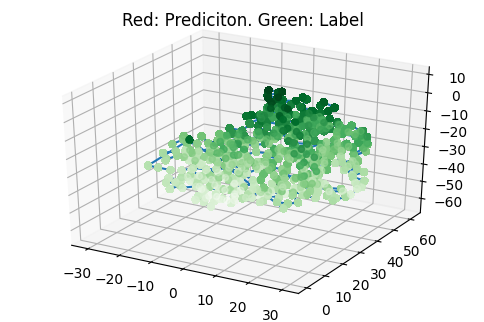

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

def draw_DNA(xp,crd):
  fig = plt.figure(dpi=100)
  
  ax = plt.axes(projection='3d')

  for i in range(0,xp.shape[0]):
    adata = xp[:,0].detach().numpy()
    bdata = xp[:,1].detach().numpy()
    cdata = xp[:,2].detach().numpy()
    ax.scatter3D(adata, bdata, cdata, c=cdata, cmap="Reds")
    
  for i in range(0,crd.shape[0]):
    # Data for three-dimensional scattered points

    xdata = crd[:,0].detach().numpy()
    ydata = crd[:,1].detach().numpy()
    zdata = crd[:,2].detach().numpy()
    
    ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap="Greens")


  ax.plot3D(xdata,ydata,zdata)
  ax.plot3D(adata,bdata,cdata)
  plt.title("Red: Prediciton. Green: Label")


draw_DNA(xp,crd)